In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Attention, Concatenate
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from tensorflow.keras.optimizers import Adam

In [28]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omerf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import tensorflow as tf

# GPU cihazlarını listele ve dinamik bellek ayarını etkinleştir
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU başarıyla etkinleştirildi.")
else:
    print("GPU bulunamadı.")

# Basit bir TensorFlow işlemi
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)  # Bu işlem GPU üzerinde çalışmalı
print(c)


GPU başarıyla etkinleştirildi.
tf.Tensor([[11.]], shape=(1, 1), dtype=float32)


In [3]:
# GPU cihazlarını listele
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"{len(gpus)} GPU bulundu:")
    for gpu in gpus:
        print(f" - {gpu.name}")
else:
    print("GPU bulunamadı.")


1 GPU bulundu:
 - /physical_device:GPU:0


In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [7]:
df_clean

,Question,Answer
0,"If you are a doctor, please answer the medical...",hello and thank you for using chatbot. i caref...
1,"If you are a doctor, please answer the medical...",hello brain tumor may present in various ways....
2,Answer this question truthfully When to seek u...,Call your health care provider if symptoms of ...
3,"If you are a doctor, please answer the medical...","hi surya, thanks for writing in. melanie cream..."
4,"If you are a doctor, please answer the medical...",hello! i read your question and understand you...
...,...,...
246673,"If you are a doctor, please answer the medical...","dear sir/ madam, thank you for posting your qu..."
246674,Answer this question truthfully What is the ot...,"The pituitary gland, also known as the hypophy..."
246675,"If you are a doctor, please answer the medical...","hello, possible causes like contusion followin..."
246676,Answer this question truthfully What are the m...,"Retinitis pigmentosa is a genetic, inherited d..."


In [2]:
data = pd.read_csv('tıbbichatbot_veriseti_augmented.csv')
data1 = data[['Question','Answer']]

In [3]:
data2 = pd.read_csv('medical_qa_dataset.csv')
data2

,Question,Answer
0,"If you are a doctor, please answer the medical...",hello and thank you for using chatbot. i caref...
1,"If you are a doctor, please answer the medical...",hello brain tumor may present in various ways....
2,Answer this question truthfully When to seek u...,Call your health care provider if symptoms of ...
3,"If you are a doctor, please answer the medical...","hi surya, thanks for writing in. melanie cream..."
4,"If you are a doctor, please answer the medical...",hello! i read your question and understand you...
...,...,...
246673,"If you are a doctor, please answer the medical...","dear sir/ madam, thank you for posting your qu..."
246674,Answer this question truthfully What is the ot...,"The pituitary gland, also known as the hypophy..."
246675,"If you are a doctor, please answer the medical...","hello, possible causes like contusion followin..."
246676,Answer this question truthfully What are the m...,"Retinitis pigmentosa is a genetic, inherited d..."


In [4]:
data3 = pd.concat([data1,data2] )
data3

,Question,Answer
0,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."
...,...,...
246673,"If you are a doctor, please answer the medical...","dear sir/ madam, thank you for posting your qu..."
246674,Answer this question truthfully What is the ot...,"The pituitary gland, also known as the hypophy..."
246675,"If you are a doctor, please answer the medical...","hello, possible causes like contusion followin..."
246676,Answer this question truthfully What are the m...,"Retinitis pigmentosa is a genetic, inherited d..."


In [5]:
data_75k = data3.head(150000)


In [7]:
data_75k.to_csv('150kTıpVeri.csv')

cut_by_sentences fonksiyonu: Verilen metni cümlelere ayırır ve ilk 5 cümleyi alıp özet olarak döner.

conditional_summarize fonksiyonu: Eğer metin 150 kelimeden uzunsa cut_by_sentences ile kısaltır, değilse olduğu gibi bırakır.

Son satırda: data_75k veri çerçevesindeki "Answer" sütunundaki her metne bu işlem uygulanır. Eğer hücredeki veri bir metinse, kontrol edilip gerekirse özetlenir.

In [ ]:
def cut_by_sentences(text, max_sentences=5):
    sentences = text.split('.')
    summary = '.'.join(sentences[:max_sentences])
    return summary.strip() + '.' if summary else ''

max_answer_len = 150  # word limit

def conditional_summarize(answer):
    if len(answer.split()) > max_answer_len:
        return cut_by_sentences(answer, max_sentences=5)
    else:
        return answer

data_75k['Answer'] = data_75k['Answer'].apply(
    lambda x: conditional_summarize(x) if isinstance(x, str) else x
)


In [11]:
data_75k = data_75k[data_75k['Answer'].str.split().str.len() > 10]

In [12]:
data_75k.shape

(70052, 2)

In [13]:
# Soruları ve cevapları ayırıyoruz
questions = data_75k['Question'].values
answers = data_75k['Answer'].values

# Küçük harfe çevirme, özel karakterlerden arındırma
def temizle(text):
    text = text.lower()  # Küçük harfe çevirme
    text = re.sub(r'\d+', '', text)  # Sayıları kaldırma
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldırma
    return text

data_75k['Question'] = [temizle(q) for q in questions]
data_75k['Answer'] = [temizle(a) for a in answers]

In [15]:
data_75k['Answer']


0        lcmv infections can occur after exposure to fr...
1        lcmv is most commonly recognized as causing ne...
2        individuals of all ages who come into contact ...
3        during the first phase of the disease the most...
4        aseptic meningitis encephalitis or meningoence...
                               ...                        
25773    analysis of the dynamic changes of serum igm a...
25774    hello adult adhd and bipolar disorder has very...
25776    sorry for the loss but every medical procedure...
25777    hello dairy understand your concernthere is no...
25778    hi opg orthopantomogram and lateral cephalogra...
Name: Answer, Length: 70052, dtype: object

In [14]:
questions = data_75k['Question'].astype(str).tolist()
answers = data_75k['Answer'].astype(str).tolist()

In [15]:
# Add start and end tokens to answers
answers_in = ['<start> ' + ans for ans in answers]
answers_out = [ans + ' <end>' for ans in answers]


In [16]:
q_train, q_val, a_train_in, a_val_in, a_train_out, a_val_out = train_test_split(
    questions, answers_in, answers_out, test_size=0.3, random_state=42
)

Tokenizer oluşturuluyor: En sık geçen 8000 kelime dikkate alınacak, filtre uygulanmıyor (filters='').

fit_on_texts: Tüm eğitim verileri (q_train, a_train_in, a_train_out) üzerinde öğrenme yapılır — yani kelimelere numara atanır.

texts_to_sequences: Eğitim ve doğrulama metinleri (soru ve cevaplar) sayısal dizilere dönüştürülür.

In [17]:
# Tokenization
num_words = 8000
tokenizer = Tokenizer(num_words=num_words, filters='')
tokenizer.fit_on_texts(q_train + a_train_in + a_train_out)

# Convert texts to sequences
q_train_seq = tokenizer.texts_to_sequences(q_train)
q_val_seq = tokenizer.texts_to_sequences(q_val)
a_train_in_seq = tokenizer.texts_to_sequences(a_train_in)
a_val_in_seq = tokenizer.texts_to_sequences(a_val_in)
a_train_out_seq = tokenizer.texts_to_sequences(a_train_out)
a_val_out_seq = tokenizer.texts_to_sequences(a_val_out)

In [18]:
max_len_q = min(max(len(seq) for seq in q_train_seq), 700)
max_len_a = min(max(len(seq) for seq in a_train_out_seq), 700)

pad_sequences fonksiyonu ile tüm diziler sabit uzunluğa getirilir:

max_len_q: soru dizileri için maksimum uzunluk.

max_len_a: cevap dizileri için maksimum uzunluk.

padding='post': Eksik kalan yerlere sondan sıfır eklenir.

vocab_size: Tüm kelimelerin sayısı (+1, çünkü 0 genelde padding için ayrılır).

reverse_word_index: Sayısal index’ten tekrar kelimeye dönmek için ters sözlük oluşturulur.

In [19]:
# Padding
q_train_seq = pad_sequences(q_train_seq, maxlen=max_len_q, padding='post')
q_val_seq = pad_sequences(q_val_seq, maxlen=max_len_q, padding='post')
a_train_in_seq = pad_sequences(a_train_in_seq, maxlen=max_len_a, padding='post')
a_val_in_seq = pad_sequences(a_val_in_seq, maxlen=max_len_a, padding='post')
a_train_out_seq = pad_sequences(a_train_out_seq, maxlen=max_len_a, padding='post')
a_val_out_seq = pad_sequences(a_val_out_seq, maxlen=max_len_a, padding='post')

vocab_size = len(tokenizer.word_index) + 1
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}


In [20]:
vocab_size

79005

Girdi: Soru dizisi (örneğin q_train_seq).

Embedding katmanı: Kelimeler sayısaldan vektöre çevrilir.

LSTM: Sıralı veriyi işler. Son hücre durumları (state_h, state_c) decoder’a aktarılır.

Girdi: Cevap başlangıç dizisi (a_train_in_seq).

Embedding yapılır.

LSTM: Decoder LSTM başlarken encoder’ın durumlarını kullanır.

Decoder’ın çıktısı ile encoder’ın tüm zamanlardaki çıktısı arasında dikkat (attention) kurulur.

Bu, decoder’ın her anda encoder’ın önemli kısımlarına odaklanmasını sağlar.

Çıktılar birleştirilir.

Model tanımlanır.

Adam optimizer ile derlenir.

Kayıp fonksiyonu olarak sparse_categorical_crossentropy seçilir (çünkü çıkışlar indeks şeklinde).

In [21]:
embedding_dim = 128
lstm_units = 128

# Encoder
encoder_inputs = Input(shape=(max_len_q,), name="encoder_inputs")
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.3)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,), name="decoder_inputs")
dec_emb_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_state=True, return_sequences=True, dropout=0.3)
dec_lstm_out, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Attention
attention_layer = Attention()
attention_out = attention_layer([dec_lstm_out, encoder_lstm_out])
concat = Concatenate(axis=-1)([dec_lstm_out, attention_out])

output_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = output_dense(concat)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0002)

model.compile(
    optimizer=opt, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 700)]        0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 700, 128)     10112640    ['encoder_inputs[0][0]']         
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    10112640    ['decoder_inputs[0][0]']         
                                                                                              

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # İzlenecek metrik (ör: val_loss veya val_accuracy)
    patience=5,           # İyileşme olmadığında kaç epoch bekleyeceği
    restore_best_weights=True # En iyi ağırlıkları geri yükler
)
history = model.fit(
    [q_train_seq, a_train_in_seq],
    np.expand_dims(a_train_out_seq, -1),
    validation_data=([q_val_seq, a_val_in_seq], np.expand_dims(a_val_out_seq, -1)),
    batch_size=1,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
49036/49036 [==============================] - 5012s 102ms/step - loss: 0.5729 - accuracy: 0.2496 - val_loss: 0.4807 - val_accuracy: 0.3348
Epoch 2/15
49036/49036 [==============================] - 5028s 103ms/step - loss: 0.4564 - accuracy: 0.3563 - val_loss: 0.4320 - val_accuracy: 0.3774
Epoch 3/15
49036/49036 [==============================] - 5028s 103ms/step - loss: 0.4189 - accuracy: 0.3875 - val_loss: 0.4049 - val_accuracy: 0.3999
Epoch 4/15
49036/49036 [==============================] - 5022s 102ms/step - loss: 0.3955 - accuracy: 0.4064 - val_loss: 0.3873 - val_accuracy: 0.4156
Epoch 5/15
49036/49036 [==============================] - 5024s 102ms/step - loss: 0.3798 - accuracy: 0.4196 - val_loss: 0.3741 - val_accuracy: 0.4280
Epoch 6/15
49036/49036 [==============================] - 5030s 103ms/step - loss: 0.3672 - accuracy: 0.4301 - val_loss: 0.3639 - val_accuracy: 0.4364
Epoch 7/15
49036/49036 [==============================] - 5033s 103ms/step - loss: 0.3573 - ac

In [ ]:
import os
os._exit(00)  # Kernel'i yeniden başlatır

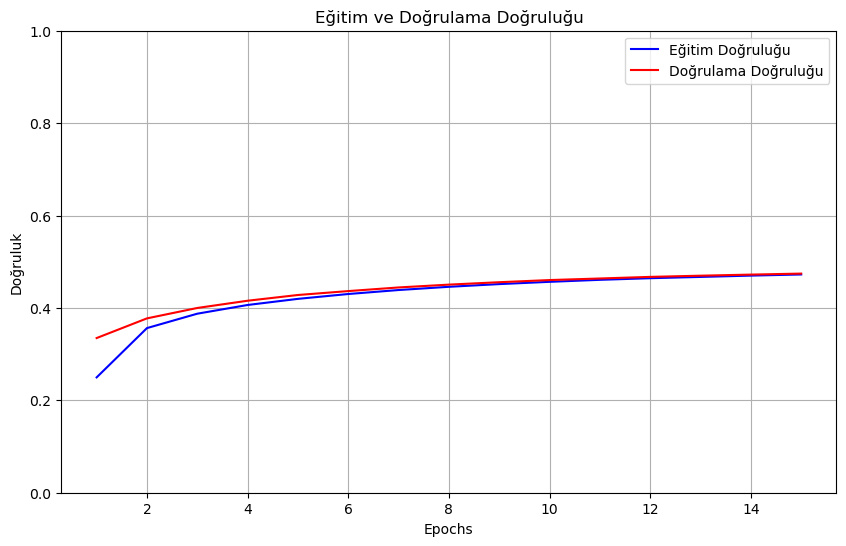

In [23]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Epoch sayısını belirle
epochs = range(1, len(train_accuracy) + 1)

# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Eğitim Doğruluğu')
plt.plot(epochs, val_accuracy, 'r-', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Y ekseni sınırlarını 0 ile 1 arasında ayarla
plt.ylim(0, 1)

plt.show()


In [25]:
model.save('chatbotModel_70_binVeri.h5')

In [24]:
def build_inference_models():
    enc_model = Model(encoder_inputs, [encoder_lstm_out, state_h, state_c])

    dec_state_input_h = Input(shape=(lstm_units,))
    dec_state_input_c = Input(shape=(lstm_units,))
    dec_hidden_input = Input(shape=(max_len_q, lstm_units))
    dec_input = Input(shape=(1,))

    dec_emb_inf = dec_emb_layer(dec_input)
    dec_out, dec_h, dec_c = decoder_lstm(dec_emb_inf, initial_state=[dec_state_input_h, dec_state_input_c])
    attn_out = attention_layer([dec_out, dec_hidden_input])
    concat_inf = Concatenate(axis=-1)([dec_out, attn_out])
    final_output = output_dense(concat_inf)

    dec_model = Model(
        [dec_input, dec_hidden_input, dec_state_input_h, dec_state_input_c],
        [final_output, dec_h, dec_c]
    )

    return enc_model, dec_model

encoder_model_inf, decoder_model_inf = build_inference_models()

In [25]:
def decode_sequence_beam_attention(input_seq, beam_width=3):
    enc_out, state_h, state_c = encoder_model_inf.predict(input_seq)
    sequences = [[[], 0.0, state_h, state_c]]

    for _ in range(max_len_a):
        all_candidates = []
        for seq, score, h, c in sequences:
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = tokenizer.word_index.get('<start>', 1) if not seq else seq[-1]
            output_tokens, h_new, c_new = decoder_model_inf.predict([target_seq, enc_out, h, c])
            output_tokens = output_tokens[0, -1, :]

            top_tokens = output_tokens.argsort()[-beam_width:][::-1]
            for token in top_tokens:
                candidate = [seq + [token], score - np.log(output_tokens[token] + 1e-9), h_new, c_new]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

        if all(reverse_word_index.get(seq[-1], '') == '<end>' for seq, _, _, _ in sequences):
            break

    best_seq = sequences[0][0]
    decoded_words = [reverse_word_index.get(idx, '') for idx in best_seq if idx != 0 and idx in reverse_word_index and reverse_word_index[idx] not in ['<start>', '<end>']]
    return ' '.join(decoded_words)


In [27]:
# Greedy decoding (faster than beam search)
def decode_sequence_greedy(input_seq):
    enc_out, state_h, state_c = encoder_model_inf.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    decoded = []

    for _ in range(max_len_a):
        output_tokens, h, c = decoder_model_inf.predict([target_seq, enc_out, state_h, state_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_word_index.get(sampled_token_index, '')
        if sampled_word == '<end>':
            break
        decoded.append(sampled_word)
        target_seq[0, 0] = sampled_token_index
        state_h, state_c = h, c

    return ' '.join(decoded)

In [28]:
from nltk.translate.bleu_score import sentence_bleu
# Fast BLEU evaluation on a subset using greedy decoding
def evaluate_model_fast(questions, references, sample_size=300):
    total_score = 0
    questions = questions[:sample_size]
    references = references[:sample_size]

    for i, question in enumerate(questions):
        input_seq = tokenizer.texts_to_sequences([question])
        input_seq = pad_sequences(input_seq, maxlen=max_len_q, padding='post')
        predicted = decode_sequence_greedy(input_seq)
        total_score += sentence_bleu([references[i].split()], predicted.split())

    return total_score / len(questions)

score = evaluate_model_fast(q_val, a_val_out, sample_size=300)
print("Fast BLEU Score (subset):", score)

1/1 [==============================] - 0s 16ms/step


C:\Users\omerf\anaconda3\envs\GPU\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 16ms/step


C:\Users\omerf\anaconda3\envs\GPU\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 16ms/step


C:\Users\omerf\anaconda3\envs\GPU\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 63ms/step
Fast BLEU Score (subset): 0.0960848330539253


In [31]:
model.save('chatbotModel_70kveri.h5')

In [ ]:
from rouge_score import rouge_scorer

sample_size = 100
references = [a.replace("<end>", "").strip() for a in a_val_out[:sample_size]]
q_val_sample = q_val_seq[:sample_size]

# ROUGE hesaplayıcı (L, 1, 2)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Tahmin üretme ve değerlendirme
for i, input_seq in enumerate(q_val_sample):
    input_seq = np.expand_dims(input_seq, axis=0)
    predicted = decode_sequence_beam_attention(input_seq)
    reference = references[i]

    scores = scorer.score(reference, predicted)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Ortalamaları yazdır
print(f"ROUGE-1 F1: {np.mean(rouge1_scores):.4f}")
print(f"ROUGE-2 F1: {np.mean(rouge2_scores):.4f}")
print(f"ROUGE-L F1: {np.mean(rougeL_scores):.4f}")

In [29]:
# örnek
for i in range(5):
    input_seq = tokenizer.texts_to_sequences([q_val[i]])
    input_seq = pad_sequences(input_seq, maxlen=max_len_q, padding='post')
    pred = decode_sequence_beam_attention(input_seq)
    print(f"\nQ: {q_val[i]}")
    print(f"GT: {a_val_out[i]}")
    print(f"Pred: {pred}")


1/1 [==============================] - 0s 69ms/step

Q: which symptoms might indicate tietz syndrome 
GT: what are the signs and signs of tietz syndrome the signs and signs of tietz syndrome are usually present at birth and may include severe bilateral both ears sensorineural hearing loss fair skin lightcolored hair blue eyes the human phenotype ontology provides the following list of signs and signs for tietz syndrome if the information is available the table below includes how often the symptom is seen in people with this condition you can use the medlineplus medical dictionary to look up the definitions for these medical terms signs and symptoms approximate number of patients when available abnormality of the anterior chamber  aplasiahypoplasia of the eyebrow  generalized hypopigmentation  hypopigmentation of hair  autosomal dominant inheritance  bilateral sensorineural hearing impairment  blue irides  congenital sensorineural hearing impairment  hypopigmentation of the fundus  whit

In [25]:
model.save('chatbot_bleu_%21.keras')

In [ ]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import pickle

# 1. Model parametreleri
#max_len_q = 26  # Encoder input shape'den
#max_len_a = 100  # Tahmini max cevap uzunluğu
vocab_size = 24905  # Dense layer output shape'den
#embedding_dim = 128  # Embedding layer'dan
#lstm_units = 128  # LSTM layer'lardan

# 2. Model ve tokenizer yükle
model = load_model('chatbotModel4.h5')


# 3. Reverse word index
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}

# 4. Encoder modeli (Model özetine göre düzenlendi)
encoder_inputs = model.input[0]  # encoder_inputs layer
encoder_embedding = model.layers[1]  # embedding layer
encoder_lstm1 = model.layers[3]  # lstm layer
encoder_lstm2 = model.layers[5]  # lstm_1 layer

# Encoder çıktıları
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_lstm1(encoder_embedding(encoder_inputs)))
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# 5. Decoder modeli (Model özetine göre tam yeniden yapılandırma)
decoder_inputs = model.input[1]  # decoder_inputs layer
decoder_embedding = model.layers[4]  # embedding_1 layer
decoder_lstm1 = model.layers[6]  # lstm_2 layer
decoder_lstm2 = model.layers[7]  # lstm_3 layer
attention_layer = model.layers[8]  # attention layer
concat_layer = model.layers[9]  # concatenate layer
decoder_dense = model.layers[10]  # dense layer

# Decoder için state girişleri
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder girişleri
dec_emb = decoder_embedding(decoder_inputs)

# 1. LSTM katmanı
decoder_lstm1_output, state_h1, state_c1 = decoder_lstm1(
    dec_emb, initial_state=decoder_states_inputs)

# 2. LSTM katmanı
decoder_lstm2_output, state_h2, state_c2 = decoder_lstm2(decoder_lstm1_output)

# Attention mekanizması
encoder_outputs_inf = Input(shape=(max_len_q, lstm_units))
attn_out = attention_layer([decoder_lstm2_output, encoder_outputs_inf])

# Concatenate
decoder_concat = concat_layer([decoder_lstm2_output, attn_out])

# Final output
decoder_outputs = decoder_dense(decoder_concat)

decoder_model = Model(
    [decoder_inputs, encoder_outputs_inf] + decoder_states_inputs,
    [decoder_outputs, state_h2, state_c2]
)

# 6. Sequence decoding fonksiyonu
def decode_sequence(input_seq):
    # Encode the input
    encoder_out, h, c = encoder_model.predict(input_seq, verbose=0)
    
    # Start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    
    decoded_sentence = []
    for _ in range(max_len_a):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_out, h, c], verbose=0)
        
        # Get most likely word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_word_index.get(sampled_token_index, '')
        
        if sampled_word == '<end>':
            break
            
        decoded_sentence.append(sampled_word)
        
        # Update target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
    
    return ' '.join(decoded_sentence)

# 7. BLEU skor hesaplama
sample_size = min(100, len(q_val_seq))
references = []
hypotheses = []

for i in range(sample_size):
    input_seq = np.expand_dims(q_val_seq[i], axis=0)
    decoded = decode_sequence(input_seq)
    
    # Prepare reference
    ref = a_val_out[i].replace('<start>', '').replace('<end>', '').strip().split()
    references.append([ref])
    
    # Prepare hypothesis
    hypotheses.append(decoded.split())

# Calculate BLEU score
smoother = SmoothingFunction().method1
bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoother)
print(f"BLEU Score: {bleu_score:.4f}")

In [7]:
# Soruları ve cevapları ayırıyoruz
questions = data['Question'].values
answers = data['Answer'].values

# Küçük harfe çevirme, özel karakterlerden arındırma
def temizle(text):
    text = text.lower()  # Küçük harfe çevirme
    text = re.sub(r'\d+', '', text)  # Sayıları kaldırma
    text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldırma
    return text

data['Question'] = [temizle(q) for q in questions]
data['Answer'] = [temizle(a) for a in answers]

In [8]:
# Extract questions and answers
questions = data['Question'].astype(str).tolist()
answers = data['Answer'].astype(str).tolist()

In [9]:
# Add start and end tokens to answers
answers_in = ['<start> ' + ans for ans in answers]
answers_out = [ans + ' <end>' for ans in answers]

# Split into training and validation sets
q_train, q_val, a_train_in, a_val_in, a_train_out, a_val_out = train_test_split(
    questions, answers_in, answers_out, test_size=0.1, random_state=42
)


In [21]:
# Tokenization
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, filters='')
tokenizer.fit_on_texts(q_train + a_train_in + a_train_out)

# Convert texts to sequences
q_train_seq = tokenizer.texts_to_sequences(q_train)
q_val_seq = tokenizer.texts_to_sequences(q_val)
a_train_in_seq = tokenizer.texts_to_sequences(a_train_in)
a_val_in_seq = tokenizer.texts_to_sequences(a_val_in)
a_train_out_seq = tokenizer.texts_to_sequences(a_train_out)
a_val_out_seq = tokenizer.texts_to_sequences(a_val_out)

In [22]:
# Determine max sequence lengths
max_len_q = max(len(seq) for seq in q_train_seq)
max_len_a = max(len(seq) for seq in a_train_out_seq)

In [23]:
max_len_q = min(max_len_q, 200)
max_len_a = min(max_len_a, 200)

In [13]:
# Padding
q_train_seq = pad_sequences(q_train_seq, maxlen=max_len_q, padding='post')
q_val_seq = pad_sequences(q_val_seq, maxlen=max_len_q, padding='post')
a_train_in_seq = pad_sequences(a_train_in_seq, maxlen=max_len_a, padding='post')
a_val_in_seq = pad_sequences(a_val_in_seq, maxlen=max_len_a, padding='post')
a_train_out_seq = pad_sequences(a_train_out_seq, maxlen=max_len_a, padding='post')
a_val_out_seq = pad_sequences(a_val_out_seq, maxlen=max_len_a, padding='post')

vocab_size = len(tokenizer.word_index) + 1

In [14]:
embedding_dim = 300
lstm_units = 512

# Encoder
encoder_inputs = Input(shape=(max_len_q,), name="encoder_inputs")
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm_out, state_h, state_c = LSTM(lstm_units,dropout=0.3, return_sequences=True, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len_a,), name="decoder_inputs")
dec_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm_out, _, _ = LSTM(lstm_units, dropout=0.3, return_sequences=True, return_state=True)(dec_emb, initial_state=encoder_states)

# Attention
attention = Attention()([decoder_lstm_out, encoder_lstm_out])
concat = Concatenate()([decoder_lstm_out, attention])

# Output layer
dec_outputs = Dense(vocab_size, activation='softmax')(concat)

# Seq2Seq Model with Attention
model = Model([encoder_inputs, decoder_inputs], dec_outputs)
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])


In [15]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 26)]         0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 300)      10247700    ['encoder_inputs[0][0]']         
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 300)     10247700    ['decoder_inputs[0][0]']         
                                                                                              

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # İzlenecek metrik (ör: val_loss veya val_accuracy)
    patience=5,           # İyileşme olmadığında kaç epoch bekleyeceği
    restore_best_weights=True # En iyi ağırlıkları geri yükler
)

history = model.fit(
     [q_train_seq, a_train_in_seq],
     np.expand_dims(a_train_out_seq, -1),
     validation_data=([q_val_seq, a_val_in_seq], np.expand_dims(a_val_out_seq, -1)),
     batch_size=2, 
     epochs=10,
     callbacks=[early_stopping]
 )


Epoch 1/10
7383/7383 [==============================] - 627s 84ms/step - loss: 2.6293 - accuracy: 0.3724 - val_loss: 2.0759 - val_accuracy: 0.4516
Epoch 2/10
7383/7383 [==============================] - 631s 85ms/step - loss: 1.8841 - accuracy: 0.4800 - val_loss: 1.8260 - val_accuracy: 0.4901
Epoch 3/10
7383/7383 [==============================] - 632s 86ms/step - loss: 1.6095 - accuracy: 0.5185 - val_loss: 1.7456 - val_accuracy: 0.5058
Epoch 4/10
7383/7383 [==============================] - 633s 86ms/step - loss: 1.4420 - accuracy: 0.5462 - val_loss: 1.7084 - val_accuracy: 0.5166
Epoch 5/10
7383/7383 [==============================] - 634s 86ms/step - loss: 1.3257 - accuracy: 0.5674 - val_loss: 1.7056 - val_accuracy: 0.5214
Epoch 6/10
7383/7383 [==============================] - 634s 86ms/step - loss: 1.2361 - accuracy: 0.5854 - val_loss: 1.7158 - val_accuracy: 0.5240
Epoch 7/10
7383/7383 [==============================] - 635s 86ms/step - loss: 1.1679 - accuracy: 0.6000 - val_loss: 1

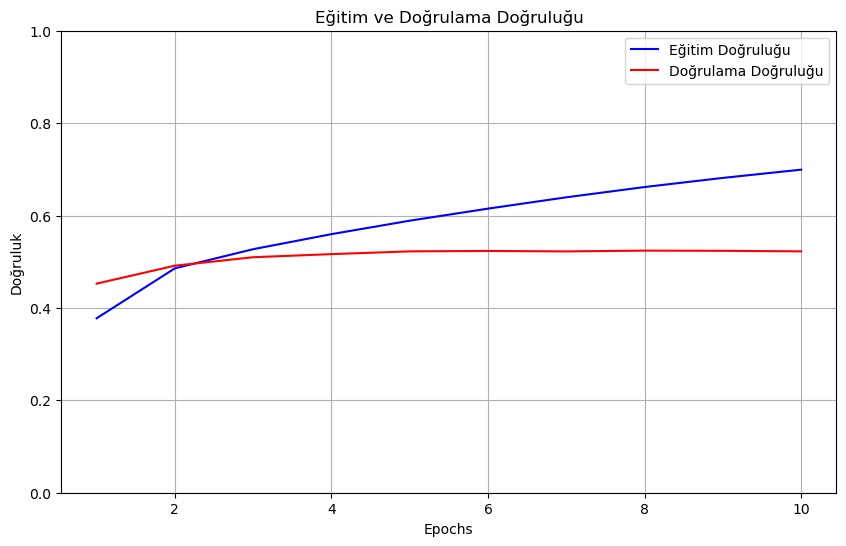

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Epoch sayısını belirle
epochs = range(1, len(train_accuracy) + 1)

# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Eğitim Doğruluğu')
plt.plot(epochs, val_accuracy, 'r-', label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Y ekseni sınırlarını 0 ile 1 arasında ayarla
plt.ylim(0, 1)

plt.show()


In [ ]:
import os
os._exit(00)  # Kernel'i yeniden başlatır

In [22]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (13125,)
y_test shape: (3282,)


In [24]:
dummy_input = np.zeros((1, max_len))  # Örnek bir giriş
dummy_output = model(dummy_input)
print("Model output shape:", dummy_output.shape)

Model output shape: (1, 100, 4673)
